In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from utils import parse_cfg, iou_vectorized, objectness_filter_and_nms, show_predictions
from darknet import Darknet

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms


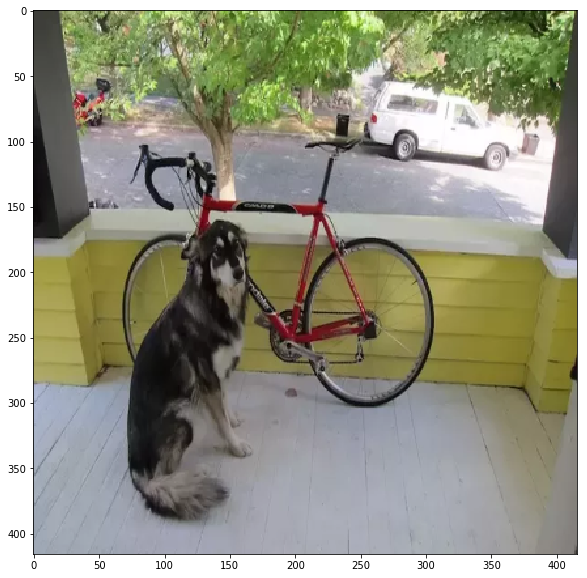

tensor(-622.6907, grad_fn=<MeanBackward1>)
tensor(-162.4865, grad_fn=<MeanBackward1>)
tensor(-63.1687, grad_fn=<MeanBackward1>)


/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[4.1600e+02, 2.8636e+02, 3.4974e-01, 1.2046e+01, 9.5918e-01, 1.2909e-01,
         3.6000e+01],
        [2.3206e+02, 1.7971e+02, 9.9373e-02, 2.3217e-02, 9.5041e-01, 9.7553e-01,
         6.7000e+01],
        [4.0291e+01, 7.7939e+01, 9.1096e-01, 1.8044e-02, 9.9431e-01, 1.1038e-03,
         5.8000e+01],
        [3.4737e+01, 7.1763e+01, 1.8557e+00, 5.6194e-01, 9.9998e-01, 7.0752e-02,
         1.2000e+01],
        [2.8316e+01, 7.5801e+00, 2.9567e+02, 7.2917e-01, 9.9996e-01, 9.9643e-01,
         2.9000e+01],
        [3.7609e+01, 7.8739e+00, 8.0543e+02, 3.6804e-01, 9.9054e-01, 9.9930e-01,
         2.9000e+01],
        [2.3885e+01, 3.8082e+00, 8.5280e+01, 1.0957e+00, 9.6640e-01, 9.9996e-01,
         2.9000e+01],
        [4.8072e+01, 6.6048e+01, 8.6195e-01, 7.6127e-03, 1.0000e+00, 9.8508e-05,
         7.5000e+01],
        [3.5523e+01, 7.4966e+01, 4.2664e+00, 9.7940e+00, 1.0000e+00, 1.4935e-01,
         7.5000e+01],
        [3.1785e+01, 4.8270e+01, 5.1520e+02, 2.9648e+00, 9.9972e-01, 8.71

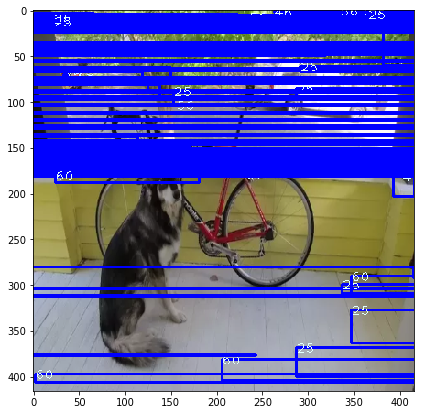

In [2]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')

weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)
darknet.eval();

from matplotlib import pyplot as plt
import cv2

plt.figure(figsize=(10, 10))

img = cv2.imread('dog-cycle-car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (416, 416))
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
pred = darknet(img, torch.device('cpu:0'))
# print('loading tensor')
# pred = torch.load('prediction.pt')
pred = objectness_filter_and_nms(pred, classes=80)
print(pred)

show_predictions('dog-cycle-car.png', pred)